HENNON HAILES

In [1]:
import numpy as np

from numpy import loadtxt

#from pyESN import ESN
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
#import pandas as pd
import torch


import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
%matplotlib inline

###  Data: <a href='https://en.wikipedia.org/wiki/Hénon–Heiles_system'>The Henon-Heiles System</a>

In [13]:
def residuals(prediction,target):
    try:
        prediction = prediction.numpy()
    except:
        pass
    try:
        target = target.numpy()
    except:
        pass
    return (target.flatten() - prediction.flatten())

In [19]:
def if_numpy(arr_or_tensor):
    if type(arr_or_tensor) == np.ndarray:
        arr_or_tensor = torch.tensor(arr_or_tensor) 
    return arr_or_tensor

class Splitter:
    
    def __init__(self, tensor, split = 0.6, noise = False, std = 0.07):
        self._split = split
        
        self._tensor = if_numpy(tensor).clone()
        self._std = std
        self._noise = noise
        if noise:
            self.make_noisy_data()
        #return self.split()
    
    def split(self):
        tl = len(self._tensor)
        trainlen = int(tl * self._split)
        train, test = self._tensor[:trainlen], self._tensor[trainlen:]
        return train, test

    def make_noisy_data(self):
        self._tensor += torch.normal(0, self._std, size = self._tensor.shape)
    
    def __repr__(self):
        strr = f"Splitter: split = {self._split},"
        if self._noise:
            strr += " noise = {self._std}"
        else:
            strr += " noise = False"
        return strr


In [20]:
#helper functions:
def plot_data(train, test, ydata):
    plt.figure(figsize=(14,8))
    plt.subplot(2,1,1)
    if isinstance(train, np.ndarray):
        train, test = torch.tensor(train), torch.tensor(test)
    trainlen, testlen = len(train), len(test)
    plt.plot(range(0,trainlen+testlen),np.hstack((train,test)),'k',label='data')
    plt.plot(range(0,trainlen), train,'g',label='train')
    plt.plot(range(trainlen,trainlen+testlen), test,'-r',label='test')
    plt.ylabel('x(t)')
    plt.legend(loc=(0.1,1.1),fontsize=18,ncol=3)
    plt.tick_params(labelbottom=False)
    plt.subplot(2,1,2)
    plt.plot(tdata,ydata,'k')
    plt.ylabel('y(t)')
    plt.tight_layout()
    plt.show()

def plotResults(trainlen, testlen, data, yfit, yhat, resTrain, resTest):
    """
    Arguments:
        trainlen: the length of the training set
        testlen: the length of the test set
        data: the entire dataset
        yfit: the prediction of the RC on the training set 
        yhat: the prediction of the RC on an unseen test set
        resTrain: training residuals
        resTest: test residuals
    """
    #data plot
    plt.figure(figsize=(14,6))
    plt.subplot(2,1,1)
    plt.plot(range(0,trainlen+testlen),data[:(trainlen+testlen)],'k',  linewidth=2, label="data")
    plt.plot(range(0,trainlen),yfit,'--g',  linewidth=2, alpha=0.9, label="train")
    plt.plot(range(trainlen,trainlen+testlen), yhat,'--r', linewidth=2,  alpha=1, label="test")
    lo,hi = plt.ylim()
    plt.plot([trainlen,trainlen],[lo+np.spacing(1),hi-np.spacing(1)],'--b',alpha=0.8, linewidth=4)
    plt.tight_layout()
    plt.ylabel('x')
    plt.legend(loc=(0.1,1.1),fontsize=18,ncol=3)

    
    #Residuals plot
    plt.subplot(2,1,2)
    plt.plot(range(0,trainlen),  np.abs(resTrain),'--g',  linewidth=2, alpha=0.9, label="train")
    plt.plot(range(trainlen,trainlen+testlen), np.abs(resTest),'--r', linewidth=2,  alpha=1, label="test")
    lo, hi = plt.ylim()
    plt.yscale("log10") 
    plt.plot([trainlen,trainlen],[lo+np.spacing(1),hi-np.spacing(1)],'--b',alpha=0.8, linewidth=4)
    plt.tight_layout()
    plt.ylabel('Residuals')



### Load the data:

In [21]:
# lines = loadtxt("filename.dat", comments="#", delimiter=",", unpack=False)
tdata = loadtxt("data/HenonHeiles/t.dat")
xdata = loadtxt("data/HenonHeiles/x.dat")
ydata = loadtxt("data/HenonHeiles/y.dat")

tdata = tdata.astype('float32')
xdata = xdata.astype('float32')
ydata = ydata.astype('float32')

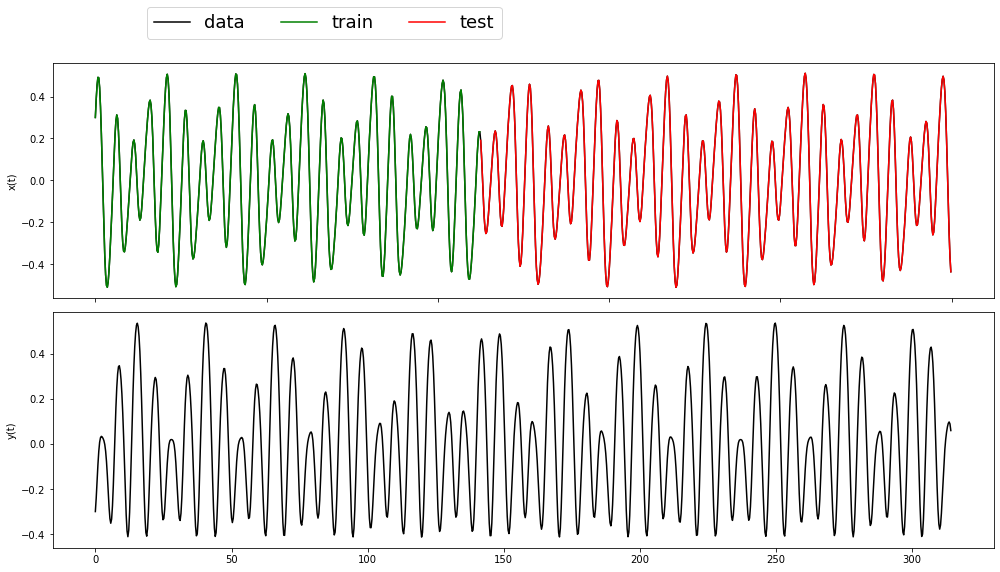

In [22]:





N = len(tdata)
# print("The time series consist of ", N, " points.")

# plt.figure(figsize=(14,6))
# plt.subplot(2,1,1)
# plt.plot(tdata,xdata,'k')
# plt.xlabel('t')
# plt.ylabel('x(t)')
# plt.subplot(2,1,2)
# plt.plot(tdata,ydata,'k')
# plt.ylabel('y(t)')
# plt.tight_layout()
# plt.show()

#split the forecast:
split = 0.45
trainlen = int(split*N)
testlen  = int((1-split)*N)
# trainlen = int(0.5*N)
# testlen  = int(0.5*N)


# Input  data equivalents:
#ttrain = np.ones(trainlen)
#ttest=np.ones(testlen)

# ttrain = tdata[:trainlen]
# ttest  = tdata[trainlen:trainlen+testlen]

ytrain = ydata[:trainlen]
ytest  = ydata[trainlen:trainlen+testlen]

# Output data
xtrain = xdata[:trainlen]
xtest = xdata[trainlen:trainlen+testlen]

# plt.figure(figsize=(14,2))

# plt.plot(range(0,trainlen), xtrain,'r')
# plt.plot(range(trainlen,trainlen+testlen), xtest,'-g')
# # plt.plot(ttrain, xtrain,'b')
# # plt.plot(ttest, xtest,'-r')
plot_data(xtrain, xtest, ydata)

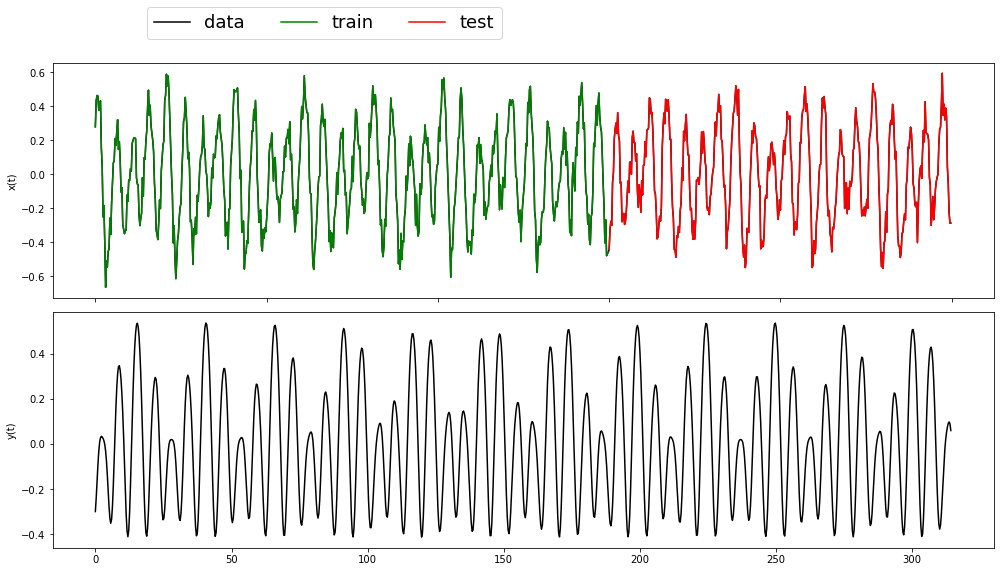

In [23]:
my_splitter = Splitter(xdata, noise = True)
xtrain_noisy, xtest_noisy = my_splitter.split()

plot_data(xtrain_noisy, xtest_noisy, ydata)

In [24]:
pure_pred_noise_hps = {'n_nodes': 500,
 'connectivity': 0.12408451143662941,
 'spectral_radius': 1.2, #1.1268014907836914,
 'regularization': 0.022762411251526036,
 'leaking_rate': 0.2863200306892395,
 'bias': 0.32563644647598267}

pp_noise_esn = My_esn(**pure_pred_noise_hps, 
            random_state = 210, 
            feedback = 1,
            n_inputs = 1,
            n_outputs = 2)
pp_noise_esn.fit(X = None, 
            y =  a,
            burn_in = 0,
            gt_override = target_train)
pp_noise_esn.test(X = None,
            y =  b,
            gt_override = target_test)

NameError: name 'My_esn' is not defined

In [25]:
pp_noise_esn.combined_plot()

NameError: name 'pp_noise_esn' is not defined

In [26]:
#declare the bounds dict. See above for which variables are optimized in linear vs logarithmic space.
bounds_dict = {"connectivity" : (-1, -0.1), 
               "spectral_radius" : (1, 2),
               "n_nodes" : 500,
               "regularization" : (-3, 3),
               "leaking_rate" : (0, 1),
               #"input_scaling" : (0, 1),
               #"feedback_scaling" : (0, 1),
               "bias": (0,1)
               }

#declare the esn_cv optimizer: this class will run bayesian optimization to optimize the bounds dict.

esn_cv = EchoStateNetworkCV(bounds = bounds_dict, esn_feedback = True, 
                            scoring_method = "nmse", interactive = True, 
                            n_jobs = 4, cv_samples = 1, initial_samples = 8, 
                            subsequence_length = int(ytrain.shape[0] * 0.8),
                            random_seed = 209, success_tolerance = 3, ODE_order = None,
                            length_min = 2**-11,
                            validate_fraction = 0.5,
                            n_inputs = 1,
                            n_outputs = 1
                            
           )
#optimize:
opt_hps = esn_cv.optimize( n_trust_regions = 2, max_evals = 500,
                            x = xtrain_noisy.reshape(-1,1), y =ytrain.reshape(-1,1))

NameError: name 'EchoStateNetworkCV' is not defined

In [27]:
# first_denoise_hps = {'n_nodes': 200,
#  'connectivity': 0.29002750025150953,
#  'spectral_radius': 1.2885233163833618,
#  'regularization': 0.013653433082063734,
#  'leaking_rate': 0.5670961141586304,
#  'bias': 0.3260454535484314}

noise_hps = {'n_nodes': 500,
 'connectivity': 0.32094487651215875,
 'spectral_radius': 1.23499596118927,
 'regularization': 0.8368901513227046,
 'leaking_rate': 0.32397231459617615,
 'bias': 0.24689573049545288}
#trained from x to y, appear to be generally good denoising parameters for this equation.

esn = EchoStateNetwork(**noise_hps, random_state = 209, feedback = 1, n_inputs = 1, n_outputs = 1)
yfit = esn.fit(X = xtrain_noisy.reshape(-1,1), y = ytrain, burn_in = 0)
scoreTest, yhat = esn.test(X = xtest_noisy.reshape(-1,1), y =ytest.reshape(-1,1))

# MSE in the training and testing
scoreTrain = myMSE(yfit,ytrain)
scoreTest = myMSE(yhat,ytest)
print("Training mean square error: ",scoreTrain)
print("Testing  mean square error: ",scoreTest)

# Residuals 
resTrain = residuals(yfit, ytrain);
resTest = residuals(yhat, ytest);

# Plot:
plotResults(trainlen, testlen, ydata, yfit, yhat, resTrain, resTest)

NameError: name 'EchoStateNetwork' is not defined

In [28]:
esn = EchoStateNetwork(**noise_hps, random_state = 209, feedback = 1, n_inputs = 1, n_outputs = 1)
xfit = esn.fit(X = xtrain_noisy.reshape(-1,1), y = xtrain, burn_in = 0)
scoreTest, xhat = esn.test(X = xtest_noisy.reshape(-1,1), y =xtest.reshape(-1,1))


# MSE in the training and testing
scoreTrain = myMSE(xfit,xtrain)
scoreTest = myMSE(xhat,xtest)
print("Training mean square error: ",scoreTrain)
print("Testing  mean square error: ",scoreTest)

# Residuals 
resTrain = residuals(xfit, xtrain);
resTest = residuals(xhat, xtest);

# Plot:
plotResults(trainlen, testlen, xdata, xfit, xhat, resTrain, resTest)

NameError: name 'EchoStateNetwork' is not defined

In [29]:
esn.extended_states.shape, esn.X.shape
# optimized_hyper_params = {'n_nodes': 200,
#  'connectivity': 0.4483155375901789,
#  'spectral_radius': 1.5525517463684082,
#  'regularization': 0.005069355134121151,
#  'leaking_rate': 0.6272786855697632,
#  'bias': 0.750773549079895}

NameError: name 'esn' is not defined

NameError: name 'esn' is not defined

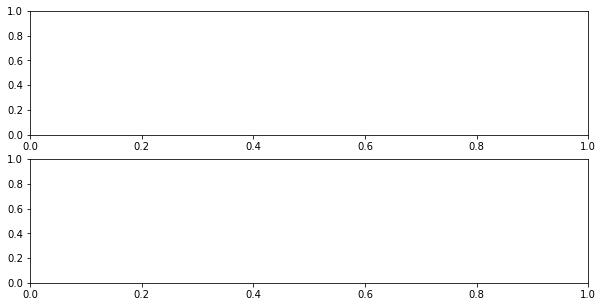

In [30]:
fig, ax = plt.subplots(2,1, figsize = (10,5))
plt.sca(ax[0])
plt.plot(torch.abs(esn.extended_states[:,0:100]), alpha = 0.3)
plt.sca(ax[1])
plt.plot(esn.val_states[:,0:5])

In [31]:
states2plot = 10
index2start = 10
valstates2plot =1000
combined_states = torch.cat((esn.extended_states[:,1:states2plot+1], esn.val_states[0:valstates2plot, 0:states2plot]))
plt.plot(combined_states[index2start:])
plt.axvline(500-index2start)

NameError: name 'esn' is not defined

In [32]:
optimized_hyper_params

NameError: name 'optimized_hyper_params' is not defined

#### Long range forecast (inference)

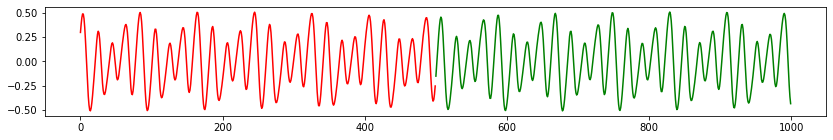

In [33]:
trainlen = int(0.5*N)
testlen  = int(0.5*N)

# Input  data
ttrain = np.ones(trainlen)
ttest=np.ones(testlen)

ytrain = ydata[:trainlen]
ytest  = ydata[trainlen:trainlen+testlen]

# Output data
xtrain = xdata[:trainlen]
xtest = xdata[trainlen:trainlen+testlen]


plt.figure(figsize=(14,2))
plt.plot(range(0,trainlen), xtrain,'r')
plt.plot(range(trainlen,trainlen+testlen), xtest,'-g')
# plt.plot(ttrain, xtrain,'b')
# plt.plot(ttest, xtest,'-r')

## RcTorch Observers Solution

In [34]:
bounds_dict = {"connectivity" : (-1, -0.1), 
               "spectral_radius" : (1, 2),
               "n_nodes" : 200,
               "regularization" : (-3, 3),
               "leaking_rate" : (0, 1),
               #"input_scaling" : (0, 1),
               #"feedback_scaling" : (0, 1),
               "bias": (0,1)
               }

esn_cv = EchoStateNetworkCV(bounds = bounds_dict, esn_feedback = True, 
                            scoring_method = "nmse", interactive = True, 
                            n_jobs = 1, cv_samples = 2, initial_samples = 10, 
                            subsequence_length = int(ytrain.shape[0] * 0.9),
                            length_min = 2**-11,
                            random_seed = 123)
optimized_hyper_params = esn_cv.optimize(y = xtrain.reshape(-1,1), x = ytrain.reshape(-1,1), 
                                         n_outputs = 1, n_trust_regions = 2, max_evals = 500)

NameError: name 'EchoStateNetworkCV' is not defined

In [ ]:
esn_cv.parallel_arguments.keys()b
esn_cv.parallel_arguments['declaration_args']

In [ ]:

opt_hps_ = hyper_params = {'n_nodes': 200,
 'connectivity': 0.13505189245513274,
 'spectral_radius': 1.6877728700637817,
 'regularization': 0.04002294006918671,
 'leaking_rate': 0.2642587423324585,
 'bias': 0.7290011644363403}


In [ ]:
esn = EchoStateNetwork(**opt_hps_, random_state = 123, feedback = 0)
xfit = esn.fit(y = xtrain, X = ytrain, burn_in = 0)
xfit = xfit.reshape(-1)
#scoreTrain, yfit = esn.test(y = ytrain)
#scoreTest, xhat = esn.test(y = xtest, X = ytest)
scoreTest, test_outputs, test_input = esn.test(y = xtest.reshape(-1,1), X = ytest)
xhat = test_outputs["yhat"]


# MSE in the training and testing
scoreTrain = myMSE(xfit, xtrain)
scoreTest = myMSE(xhat, xtest)
print("Training mean square error: ",scoreTrain)
print("Testing  mean square error: ",scoreTest)

# Residuals 
resTrain = residuals(xfit,xtrain);
resTest = residuals(xhat,xtest);

# Plot:
plotResults(trainlen, testlen, xdata, xfit, xhat, resTrain, resTest)

In [ ]:
plt.plot(test_outputs["yhat"])
plt.plot(test_outputs['ytest'])

In [ ]:
plt.plot(esn.X_val_extended.detach())

In [ ]:
plt.plot(esn.extended_states[:,:10]); torch.std(esn.extended_states[:,0])

In [ ]:
esn = EchoStateNetwork(**hyper_params, random_state = 209, feedback = 0)
xfit = esn.fit(y = xtrain, burn_in = 0)
print(xfit[0].shape)
xfit = xfit.reshape(-1)
#return score, {"yhat": y_predicted.data, "ytest": y}, X[self.burn_in:]
scoreTest, test_outputs, test_input = esn.test(y = xtest.reshape(-1,1))
xhat = test_outputs["yhat"]


# MSE in the training and testing
scoreTrain = myMSE(xfit,xtrain)
scoreTest = myMSE(xhat,xtest)
print("Training mean square error: ",scoreTrain)
print("Testing  mean square error: ",scoreTest)

# Residuals 
resTrain = residuals(xfit, xtrain);
resTest = residuals(xhat, xtest);

# Plot:
plotResults(trainlen, testlen, xdata, xfit, xhat, resTrain, resTest)

### GRU Attempt

In [ ]:
# %%time
# HIDDEN_DIM = 100
# OUTPUT_DIM = 2
# my_gru = torch.nn.GRU(input_size = 1, hidden_size = HIDDEN_DIM, num_layers = 1)
# linout = nn.Linear(HIDDEN_DIM, OUTPUT_DIM)
# relu = nn.ReLU()

# loss = torch.nn.MSELoss()


# optimizer = torch.optim.Adam(my_gru.parameters(), lr=0.01, betas=(0.9, 0.999), 
#                              eps=1e-08, weight_decay=0, amsgrad=False)
# input = input_tr
# print(input.shape)
# my_gru.train()
# for e in range(10000):
#     optimizer.zero_grad()
    
#     H, _ = my_gru(input.view(-1,1,1))
#     y_pred = linout(relu(H))
#     y_pred = y_pred.view(-1, OUTPUT_DIM)

#     assert y_pred.shape == target_tr.shape, f'{y_pred.shape} != {target_tr.shape}' 
#     L = loss(y_pred, target_tr)
    
#     L.backward()
#     optimizer.step()
    
#     #output[0].shape, output[1].shape
    
#     if e %10 == 0:
#         print(e, L)
#         if e %100 == 0:
#             plt.plot(y_pred.detach().view(-1,2))
#             plt.show()
            


### Unclear if these functions matter. Were pulled from forced_pendulum.ipynb

In [ ]:

# def myMSE(prediction,target):
#     try:
#         prediction = prediction.numpy()
#     except:
#         pass
#     return np.sqrt(np.mean((prediction.flatten() - target.flatten() )**2))

# def figure_1(data_lst):
#     fig, ax = plt.subplots(len(data_lst),2,figsize = (16,16))
#     ax = ax.flatten()
#     for i, data in enumerate(data_lst):
#         for trajectory in data:
#             #print(trajectory)
#             phase_plot(trajectory, ax = ax[i*2])
#             ax[i*2 + 1].plot(t, trajectory[:,0], color = "red")
#             ax[i*2 + 1].plot(t, trajectory[:,1], color = "blue")
#     plt.tight_layout()

# def phase_plot(data, force = None, ax = None):
#     ax.plot(data[:,0], data[:,1])
